# **Using the STLAB in asynchronous mode**
The STLAB has an **asynchronous** mode of operation which allows for real-time spectral streaming with a spectral switching time of less than 10 milliseconds (i.e. 1 spectrum every 10 milliseconds). The asynchronous mode can be used to attain precise control over the temporal properties of light stimuli, but to use it we need to create **video files**, which are basically json files with a .dsf (dynamic sequence file) extension. This notebook looks at some of the tools I've developed for creating video files.

In [1]:
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import stlab

In [71]:
d = stlab.Device(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete.


### **Light pulses**
A pulse of light is the most common stimulus for eliciting a PLR, so I made a convenient function for making a video file that will deliver a given spectrum of light for a given duration. In the following example, `stlab.make_video_pulse(...)` is used to create a video file that will deliver a 3s pulse of white light. Note that the default approach is to end video files by setting the intensity of all LEDs to 0 for 100 ms. This ensures that the light is turned off at the end. 

In [2]:
df = stlab.make_video_pulse(pulse_spec=[1000]*10, 
                            pulse_duration=3000, 
                            video_nm="3s_white", 
                            return_df=True)
df

"3s_white.dsf" saved in the current working directory.


,time,primary-0,primary-1,primary-2,primary-3,primary-4,primary-5,primary-6,primary-7,primary-8,primary-9
0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,3000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2,3000,0,0,0,0,0,0,0,0,0,0
3,3100,0,0,0,0,0,0,0,0,0,0


This is quite a small video file, so let's look at the internal structure.

In [3]:
with open('3s_white.dsf') as f:
    print(f.read())

{"header": {"version": "1", "model": "VEGA10", "channels": 10, "spectracount": 4, "transitionsCount": 4, "fluxReference": 0, "repeats": 1}, "metadata": {"creationTime": "2020-07-02 10:26:16.238955", "creator": "jtm"}, "spectra": [[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "transitions": [{"spectrum": 0, "power": 100, "time": 0, "flags": 0}, {"spectrum": 1, "power": 100, "time": 3000, "flags": 0}, {"spectrum": 2, "power": 100, "time": 3000, "flags": 0}, {"spectrum": 3, "power": 100, "time": 3100, "flags": 0}]}


The following notes on video files are based on communications with Ledmotive: 

**1. HEADER**
 - **"version"**, **"models"** and **"channels"** should not be changed, as they are the default settings for the STLAB. They get defined by the `stlab.make_video_file(...)` function.
 - **"repeats"** is set to 1 by default, meaning the video will not run endlessly. Setting "repeats" to 0 will cause the video to start again after it finishes and repeat endlessly. 
 - **"spectraCount"** is the number of different spectra used in the video. In this example we used 4 spectra (although only two were unique).
 - **"transitionsCount"** is the total number of transitions in the video. In this example there are 4 different transitions.
 - **"fluxReference"** is reserved for something else, and is fine like this.
 
**2. METADATA** 
 - This is optional, not needed. Defined by `stlab.make_video_file(...)`.
 
**3. SPECTRA**
 - These are the values (between 0 and 4095) for each of the 10 channels. Spectra should be stored as a list of lists.
 
**4. TRANSITIONS**
 - **"spectrum"** looks at the index from the list of lists to pick up the proper spectrum. This is set based on the index of the DataFrame passed to `stlab.make_video_file(...)`.
 - **"power"** assigns the power of the spectrum - can leave this at 100.
 - **"time"** is the start of the current spectrum in milliseconds time since the start of video file playback. Here the 1st spectrum starts at t=0sec, the 2nd spectrum stats at t=3sec.
 - **"flags"** is set to 0 by default, and need not be changed.

Now, we can load and play the video file.

In [80]:
d.load_video_file("3s_white.dsf")
d.play_video_file()

<Response [200]>

After running the code in the previous cell (if all has gone to plan...), the STLAB should light up for 3 s.

It may also be desireable to present a light pulse against a background of light. For these situations, there is `stlab.make_video_pulse_background(...)`, a function that will create a video file based on specifications of the background spectrum, the pulse spectrum, and the required durations. Here we use this function to generate a video file that will deliver a 500 ms pulse of blue light against a dim background of white light lasting for 5 s either side. 

In [4]:
df = stlab.make_video_pulse_background(background_spec=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000], 
                                       pre_background_duration=5000, 
                                       pulse_spec=[1000,1000,1000,4095,4095,1000,1000,1000,1000,1000],
                                       pulse_duration=500, 
                                       post_background_duration=5000, 
                                       video_nm="5sw-.5sb-5sw", 
                                       return_df=True)
df

"5sw-.5sb-5sw.dsf" saved in the current working directory.


,time,primary-0,primary-1,primary-2,primary-3,primary-4,primary-5,primary-6,primary-7,primary-8,primary-9
0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,5000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2,5000,1000,1000,1000,4095,4095,1000,1000,1000,1000,1000
3,5500,1000,1000,1000,4095,4095,1000,1000,1000,1000,1000
4,5500,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
5,10500,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
6,10500,0,0,0,0,0,0,0,0,0,0
7,10600,0,0,0,0,0,0,0,0,0,0


In [84]:
d.load_video_file("5sw-.5sb-5sw.dsf")
d.play_video_file()

<Response [200]>

### **Sinusoidal modulations**
More complex stimulus patterns are possible with some further customisation. Th following functions can make sinusoidal modulations based on frequency, duration and intensity settings. The first function creates a time vector for the video file based on duration and the maximum spectral switching rate of the system (i.e. 1 spectrum every 10 ms, or 100 Hz). The second function generates a sinusoidal modulation based on frequency and duration, and the third modulates the sinusoid with the desired intensity values.

In [5]:
def get_sinusoid_time_vector(duration):
    t = np.arange(0, (duration * 1000), 10).astype("int")
    return t

def sinusoid_modulation(f, duration, Fs=100):
    x  = np.arange(duration * Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm

def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm * amplitude)).astype("int")
    return ivals

Let's make some more video files that will modulate the output of all channels sinusoidally between the minimum and maximum intensity for 60 s. We'll do this for 5 different frequencies and plot the stimulus profiles. 

"f2dur60.dsf" saved in the current working directory.
"f1dur60.dsf" saved in the current working directory.
"f0.5dur60.dsf" saved in the current working directory.
"f0.1dur60.dsf" saved in the current working directory.
"f0.05dur60.dsf" saved in the current working directory.


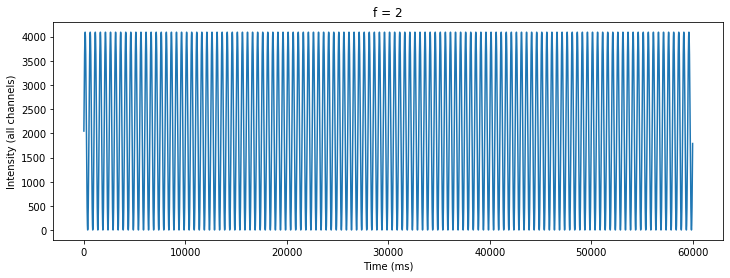

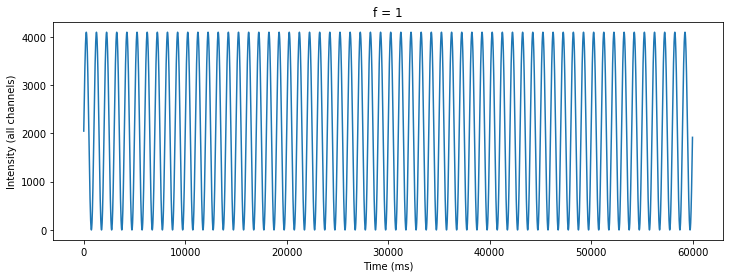

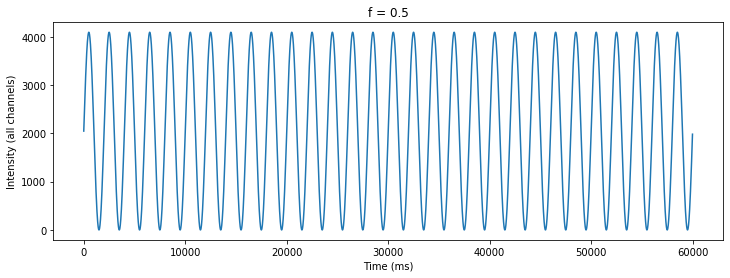

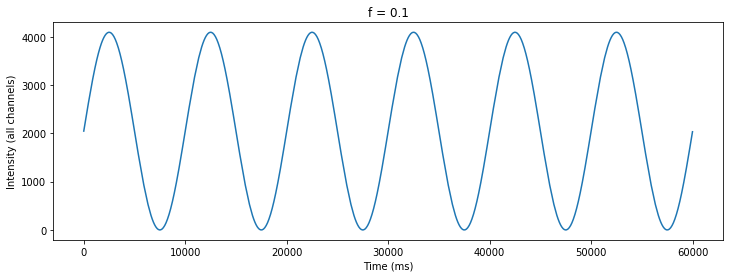

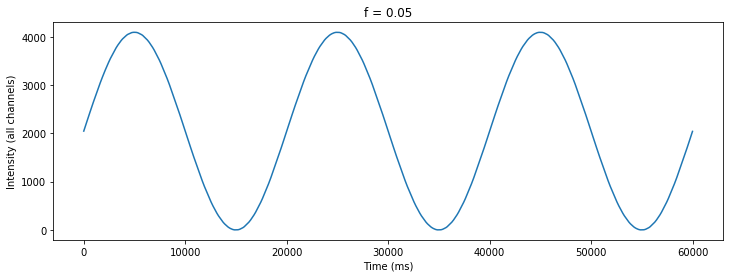

In [6]:
# STLAB params
Fs = 100 # the 'sampling' frequency of the system
mintensity = 0
maxtensity = 4095

# stimulus params
background  = maxtensity/2
amplitude   = maxtensity/2
frequencies = [2, 1, 0.5, 0.1, 0.05]
duration = 60 # s

# make the stimuli
for freq in frequencies:
    
    # time vector for dsf file
    time = get_sinusoid_time_vector(duration)
    
    # sinusoidal modulation for led channel
    sm = sinusoid_modulation(freq, duration, Fs)
    
    # get intensity values
    ivals = modulate_intensity_amplitude(sm, background, amplitude)
    
    # plot
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(time, ivals)
    ax.set_ylabel("Intensity (all channels)")
    ax.set_xlabel("Time (ms)")
    ax.set_title(f"f = {freq}")

    # make video files
    cols = stlab.get_video_cols()
    data = [ivals for x in range(10)]
    data.insert(0, time)
    df = pd.DataFrame(data, cols).T
    fname = f"f{str(freq)}dur{str(duration)}"
    stlab.make_video_file(df, fname)

Now we can choose one of them to play.

In [87]:
d.load_video_file("f2dur60.dsf")
d.play_video_file()
sleep(10.)
d.play_video_file(stop=True)

<Response [200]>

Using the above principles we can create even more complex modulations. For example, Baden et al. use a 'chirp' stimulus, which involves sinusoidal luminance modulations with additional modulations in the time and frequency domain. 

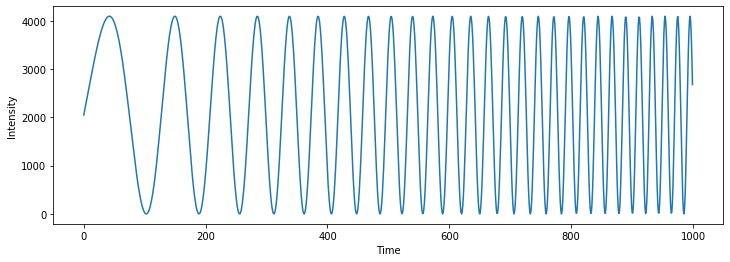

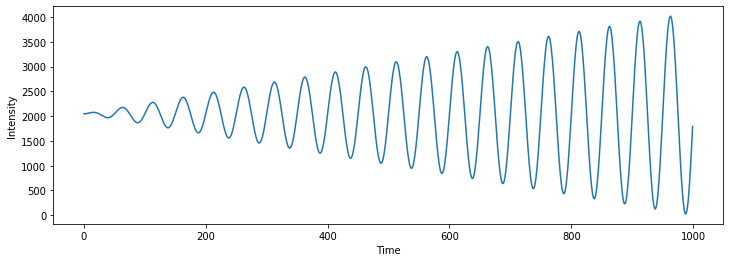

In [8]:
from scipy.signal import chirp

# stimulus params
background  = maxtensity/2
amplitude   = maxtensity/2
duration = 10
n = 1000
t = np.linspace(0, duration, n, endpoint=False)
f0 = .5
f1 = 5

# define frequency modulation
chp = chirp(t, f0, duration, f1, method='linear', phi=270)
chp = modulate_intensity_amplitude(chp, background, amplitude)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(chp)
ax.set_ylabel("Intensity")
ax.set_xlabel("Time")

# define amplitude modulation
time  = get_sinusoid_time_vector(duration)
sm = sinusoid_modulation(2, duration, Fs)
ivals = modulate_intensity_amplitude(sm, background, np.linspace(0,amplitude,duration*Fs))
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ivals)
ax.set_ylabel("Intensity")
ax.set_xlabel("Time");

Now we can use these modulations as sort of building blocks to define a more complex stimulus profile. In what follows, we recreate the stimulus time course from Baden et al.

"baden_chirp.dsf" saved in the current working directory.


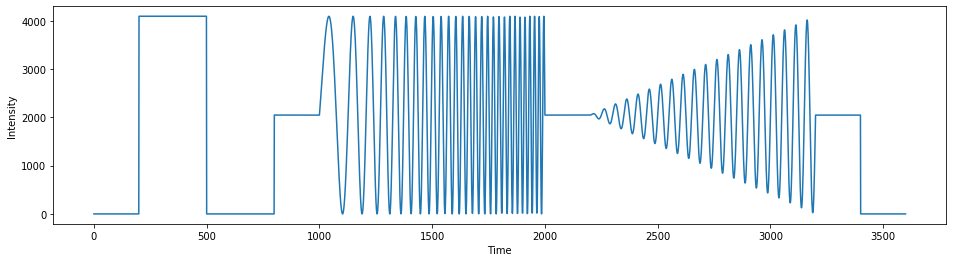

In [9]:
duration=36
time = get_sinusoid_time_vector(duration)
stim = np.zeros(duration*Fs)

# assemble time course
stim[200:500]   = 4095 # pulse
stim[800:1000]  = 2048 # step
stim[1000:2000] = chp  # chirp
stim[2000:2200] = background
stim[2200:3200] = ivals
stim[3200:3400] = background
stim = stim.astype('int')

# plot
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(stim)
ax.set_ylabel("Intensity")
ax.set_xlabel("Time")

# make video file
cols = stlab.get_video_cols()
data = [stim for x in range(10)]
data.insert(0, time)
df = pd.DataFrame(data, cols).T
fname = "baden_chirp"
stlab.make_video_file(df, fname)

In [104]:
d.load_video_file("baden_chirp.dsf")
d.play_video_file()

<Response [200]>